Alunos: Ana Carolina da Silva e Gustavo Baroni Bruder

Importação das bibliotecas

- opencv: leitura do vídeo, captura de frames e salvamento de imagens
- pandas: armazenar, filtrar, ordenar e exportar os dados
- matplot: plotar graficamente os resultados obtidos
- yolo: carregar e aplicar o modelo de detecção de objetos

In [1]:
import cv2
import os
import pandas as pd
import matplotlib.pyplot as plt
from ultralytics import YOLO

Extração dos frames

- O vídeo escolhido faz parte do dataset UA-DETRAC que possui vídeos de tráfego urbano
- Limitação em 100 frames feita de forma arbitrária pelo gasto de tempo de execução
- Separação dos 100 frames que serão analisados posteriormente

In [2]:
video_path = "src/videos/39031.avi"
frame_limit = 100
os.makedirs("src/frames", exist_ok=True)

cap = cv2.VideoCapture(video_path)
success, frame = cap.read()
frame_count = 0

while success and frame_count < frame_limit:
    frame_file = f"src/frames/frame_{frame_count:04d}.jpg"
    cv2.imwrite(frame_file, frame)
    success, frame = cap.read()
    frame_count += 1

Inicialização do modelo pré-treinado

- O modelo YOLOv5 é especializado em detecção de objetos em imagens e vídeos
- Permite obter bounding boxes, classes e a confiabilidade das detecções

In [3]:
model = YOLO("yolov5su.pt")

Contagem das classes identificadas pelo modelo

- Criação de uma variável para armazenar a contagem de classes detectadas
- Algoritmo para realizar a leitura dos frames separados anteriormente
- Utilização do modelo para detecção das classes
- Atualização das contagens das classes detectadas

In [4]:
total_count = {}
total_labels_confs = {}

def update_count(detected_labels):
    for label, conf in detected_labels:
        total_count[label] = total_count.get(label, 0) + 1

        if label not in total_labels_confs:
            total_labels_confs[label] = []
        total_labels_confs[label].append(conf)
        

for i in range(frame_count):
    frame_path = f"src/frames/frame_{i:04d}.jpg"
    results = model(frame_path, verbose=False)[0]
    labels_confs = []
    for box in results.boxes:
        label = model.names[int(box.cls)]
        conf = float(box.conf[0])
        labels_confs.append((label, conf))
    update_count(labels_confs)

Visualização dos resultados encontrados

- A relação entre classes e contagens obtidas exportada em arquivo CSV
- Gráfico de barras exibindo a contagem obtida por classe


Contagem final por classe:

    Class  Quantity
0     car       338
1  person        90


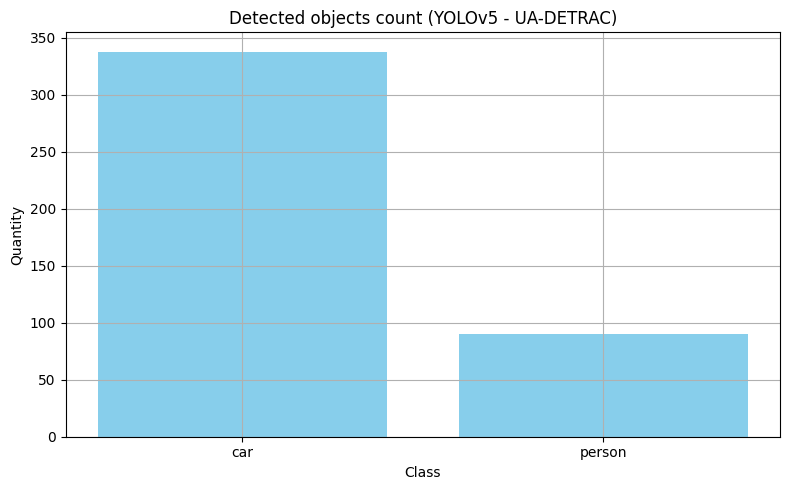

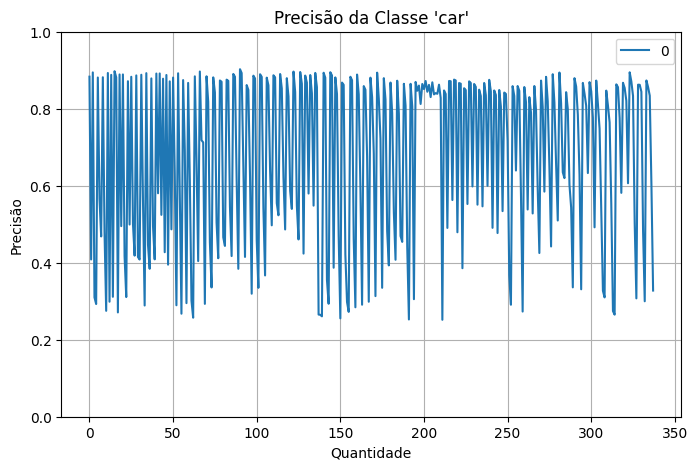

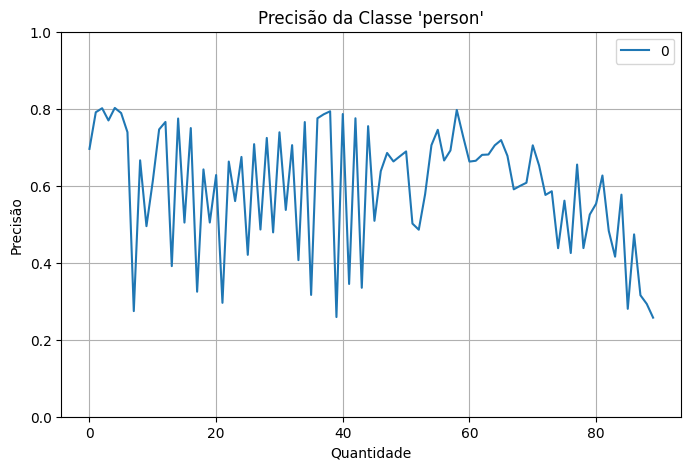

In [5]:
df = pd.DataFrame(total_count.items(), columns=["Class", "Quantity"])
urban_classes = ["car", "truck", "bus", "motorbike", "bicycle", "person"]
df = df[df["Class"].isin(urban_classes)]
df.sort_values("Quantity", ascending=False, inplace=True)
df.to_csv("final_count.csv", index=False)

print("\nContagem final por classe:\n")
print(df)

# gráficos

plt.figure(figsize=(8, 5))
plt.bar(df["Class"], df["Quantity"], color="skyblue")
plt.title("Detected objects count (YOLOv5 - UA-DETRAC)")
plt.ylabel("Quantity")
plt.xlabel("Class")
plt.grid(True)
plt.tight_layout()
plt.show()

for label, confs in total_labels_confs.items():
    pd.DataFrame(confs).plot(figsize = (8, 5), label=label)
    plt.title(f"Precisão da Classe '{label}'")
    plt.xlabel('Quantidade')
    plt.ylabel('Precisão')
    plt.ylim(0, 1)  # métrica de 0 a 1
    plt.grid(True)
    plt.show()